# FK cropping and summing

This notebook displays the vfk_crop_sum functionality, which crops in velocity, frequency and wavenumber and then sums.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from das_fk import to_fk_domain, vfk_crop_sum
from das_fk.utils import read_PASSCAL_segy, downsample_das, split_time_spatial
from das_fk.visualization import plot_fk, plot_velocity, timeseries_ridgeplot


# Channel positions

In [2]:
location = pd.read_csv("../data/das_info.csv")
location.head()

,index,latitude,longitude,elevation_m
0,25,35.645200,-117.667931,0.0
1,26,35.645272,-117.667929,0.0
2,27,35.645344,-117.667928,0.0
3,28,35.645416,-117.667927,0.0
4,29,35.645488,-117.667926,0.0


In [3]:
location_new = location[120:]

# Preprocess

In [4]:
channel_index = location_new["index"].to_numpy()
channel_lat = location_new["latitude"].to_numpy()
channel_lon = location_new["longitude"].to_numpy()

In [5]:
data, das_time = read_PASSCAL_segy("../data/2020062417.segy")

In [6]:
# Option 1: Downsample the data.
strain, das_time = downsample_das(data[channel_index, :], das_time, fd=25)

# Option 2: Don't downsample
# strain = data[channel_index, :]

# Option 3: Just downsample
# strain, das_time = downsample_das(data, das_time, fd=25)

# Option 4: Don't downsample and keep all channels
# strain = data

In [7]:
# Highpass filter
# Mainly to drop DC component
from scipy.signal import butter, sosfiltfilt

dt = das_time[1] - das_time[0] # (it is constant)
dl = 10
sos = butter(4, 0.5*2*dt, output='sos', btype='high')
strain_filt = sosfiltfilt(sos, strain, axis=1)

In [8]:
# Median filter
# For salt and pepper noise, outliers and bad channels.
from scipy.signal import medfilt2d

kernel_size = (3,1) # Only along channels
strain_prep = medfilt2d(strain_filt, kernel_size=kernel_size)

# Visualize

In [9]:
start_id = np.argmin(np.abs(das_time-2475))
stop_id = np.argmin(np.abs(das_time-2525))
start_id, stop_id

(61875, 63125)

In [10]:
# Split into time-spatial blocks
dT = 3 # seconds
dL = 1000 # meters
strain_time_spatial = split_time_spatial(strain_prep, dT=dT, dL=dL, dt=dt, dl=dl)
print("strain_time_spatial.shape: ", strain_time_spatial.shape)

strain_time_spatial.shape:  (10, 1200, 75, 100)


In [11]:
strain_time_spatial_fk, frequency, wavenumber = to_fk_domain(strain_time_spatial, dt=dt, dl=dl)
print("strain_time_spatial_fk.shape: ", strain_time_spatial_fk.shape)

strain_time_spatial_fk.shape:  (10, 1200, 51, 75)


In [12]:
strain_time_spatial_power = np.abs(strain_time_spatial_fk)

In [13]:
# v = (3000, np.inf)
# f = (1, 50)
# k = (0.006, 0.01)

v = (0, np.inf)
f = (0, 13)
k = (0, 0.05)

total_sum = vfk_crop_sum(strain_time_spatial_power, v, f, k, dt, dl=dl)
print("cropped_sum.shape: ", total_sum.shape)

c:\users\usuario\onedrive - universidad técnica federico santa maría\escritorio\das\das_fk_analysis\das_fk\fk.py:105: UserWarning: 
Invalid frequency range. Valid range: (0, 12.377450980392156)

  warnings.warn(f"\nInvalid frequency range. Valid range: (0, {max_f})\n")
c:\users\usuario\onedrive - universidad técnica federico santa maría\escritorio\das\das_fk_analysis\das_fk\fk.py:107: UserWarning: 
Invalid wavenumber range. Valid range: (0, 0.04933333333333333)

  warnings.warn(f"\nInvalid wavenumber range. Valid range: (0, {max_k})\n")


cropped_sum.shape:  (10, 1200)


Text(0.5, 1.0, 'Total sum for each section along time')

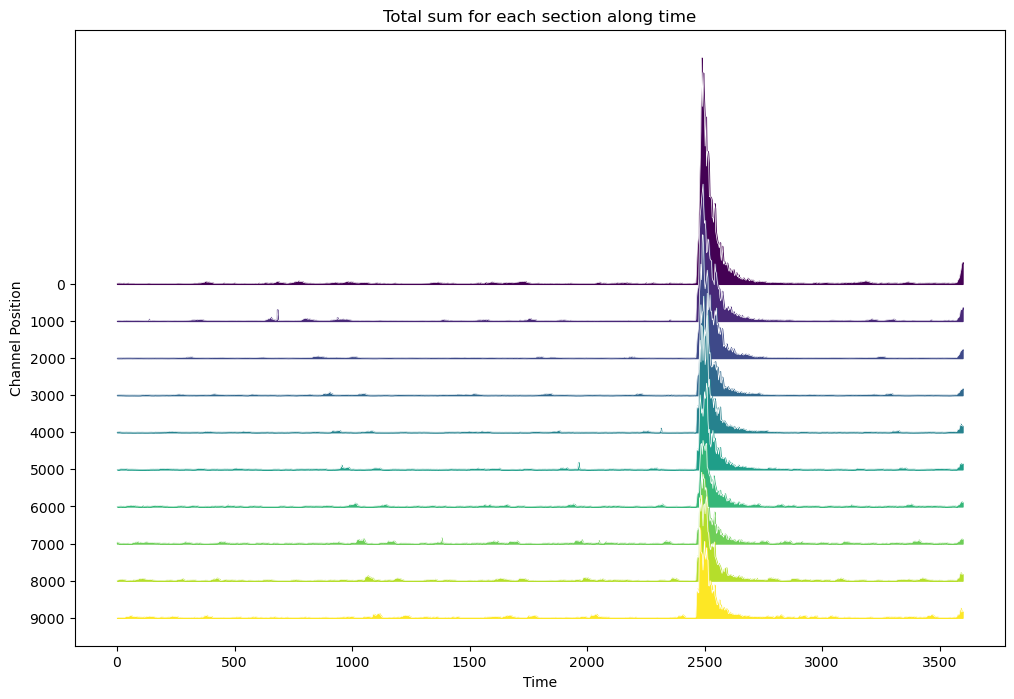

In [14]:
fig, ax = timeseries_ridgeplot(total_sum, dT=dT, dL=dL, figsize=(12,8))
plt.title("Total sum for each section along time")


Text(0.5, 1.0, 'Earthquake fk-domain')

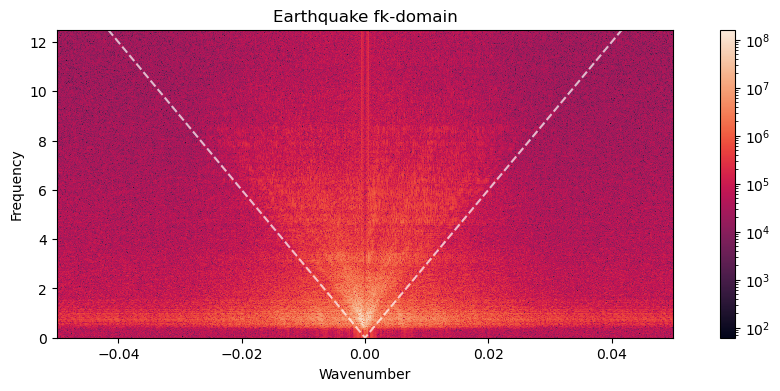

In [15]:
strain_earthquake = strain_prep[:, start_id:stop_id]
strain_earthquake_fk, frequency, wavenumber = to_fk_domain(strain_earthquake,
                                                           dt=dt, dl=dl)
strain_earthquake_power = np.abs(strain_earthquake_fk)
fig, ax = plot_fk(strain_earthquake_power, frequency, wavenumber)
plot_velocity(300, frequency, wavenumber, ax, color="w")
plt.title("Earthquake fk-domain")


In [16]:
v = (300, np.inf)
f = (1, 50)
k = (0.006, 0.02)

cropped_sum = vfk_crop_sum(strain_time_spatial_power, v, f, k, dt, dl=dl)
print("cropped_sum.shape: ", cropped_sum.shape)

cropped_sum.shape:  (10, 1200)


Text(0.5, 1.0, 'Cropped sum for each section along time')

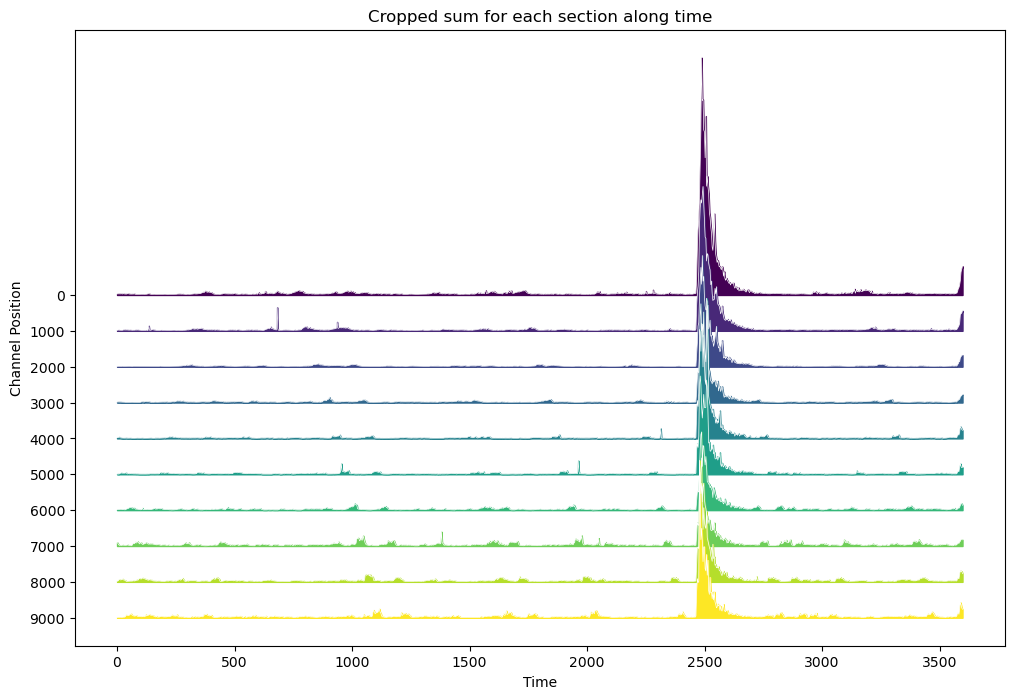

In [17]:
fig, ax = timeseries_ridgeplot(cropped_sum, dT=dT, dL=dL, figsize=(12,8))
plt.title("Cropped sum for each section along time")
